In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, pairs_from_covisibility
from hloc import triangulation, localize_sfm, visualization
from hloc import retrieval, pairs_from_retrieval

Using cache found in /root/.cache/torch/hub/yxgeee_OpenIBL_master


# Pipeline for outdoor day-night visual localization

## Setup
Here we declare the paths to the dataset, the reconstruction and localization outputs, and we choose the feature extractor and the matcher. You only need to download the [Aachen Day-Night dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/aachen/`, or change the path.

In [2]:
dataset_name = 'aachen'
dataset = Path('datasets') / dataset_name
images = dataset / 'images/images_upright/'

pairs = Path('pairs') / dataset_name
pairs.mkdir(parents=True, exist_ok=True)
sfm_pairs = pairs / 'pairs-db-covis20.txt'
loc_pairs = pairs / 'pairs-query-netvlad50.txt'

outputs = Path('outputs') / dataset_name
reference_sfm = outputs / 'sfm_superpoint+superglue'
triangulated_sfm = outputs / 'sfm_superpoint+superglue_triangulated'
results = outputs / (dataset_name + '_hloc_superpoint+superglue_netvlad50.txt')

global_descriptor_name = "openibl_4096.h5"

In [3]:
# list the standard configurations available
print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

Configs for feature extractors:
{'d2net-ss': {'model': {'multiscale': False, 'name': 'd2net'},
              'output': 'feats-d2net-ss',
              'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'dir': {'model': {'name': 'dir'},
         'output': 'global-feats-dir',
         'preprocessing': {'resize_max': 1024}},
 'netvlad': {'model': {'name': 'netvlad'},
             'output': 'global-feats-netvlad',
             'preprocessing': {'resize_max': 1024}},
 'r2d2': {'model': {'max_keypoints': 5000, 'name': 'r2d2'},
          'output': 'feats-r2d2-n5000-r1024',
          'preprocessing': {'grayscale': False, 'resize_max': 1024}},
 'sift': {'model': {'name': 'sift'},
          'output': 'feats-sift',
          'preprocessing': {'grayscale': True, 'resize_max': 1600}},
 'superpoint_aachen': {'model': {'max_keypoints': 4096,
                                 'name': 'superpoint',
                                 'nms_radius': 3},
                       'output': 'feats-super

In [4]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Extract local features for database and query images

In [5]:
feature_path = extract_features.main(feature_conf, images, outputs)

[01/11/2022 04:36:21.846Z] INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[01/11/2022 04:36:21.982Z] INFO] Found 5426 images in root datasets/aachen/images/images_upright.
[01/11/2022 04:36:21.984Z] INFO] Start delete query feature: outputs/aachen/feats-superpoint-n4096-r1024.h5
[01/11/2022 04:36:22.024Z] INFO] Start skip pairs: outputs/aachen/feats-superpoint-n4096-r1024.h5
Loaded SuperPoint model
[01/11/2022 04:36:25.378Z] INFO] Finished setup model for feature extraction


 83% 4477/5426 [01:07<00:14, 66.56it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100% 5426/5426 [01:44<00:00, 52.09it/s]

[01/11/2022 04:38:09.556Z] INFO] Finished exporting features.


The function returns the path of the file in which all the extracted features are stored.

## Generate pairs for the SfM reconstruction
Instead of matching all database images exhaustively, we exploit the existing SIFT model to find which image pairs are the most covisible. We first convert the SIFT model from the NVM to the COLMAP format, and then do a covisiblity search, selecting the top 20 most covisibile neighbors for each image.

In [6]:
pairs_from_covisibility.main(
    reference_sfm, sfm_pairs, num_matched=20)

[01/11/2022 04:38:09.596Z] INFO] Reading the COLMAP model...
[01/11/2022 04:38:35.769Z] INFO] Extracting image pairs from covisibility info...


 37% 1591/4328 [00:17<00:34, 79.44it/s] 

[01/11/2022 04:38:53.728Z] INFO] Image 3302 does not have any covisibility.


 38% 1657/4328 [00:18<00:27, 96.94it/s]

[01/11/2022 04:38:54.560Z] INFO] Image 3297 does not have any covisibility.


 42% 1831/4328 [00:20<00:20, 122.32it/s]

[01/11/2022 04:38:56.079Z] INFO] Image 1167 does not have any covisibility.


100% 4328/4328 [00:48<00:00, 90.06it/s] 

[01/11/2022 04:39:23.830Z] INFO] Found 85614 pairs.


## Match the database images

In [7]:
sfm_match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[01/11/2022 04:39:25.523Z] INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
Loaded SuperGlue model ("outdoor" weights)
[01/11/2022 04:39:29.735Z] INFO] Start delete query matching: outputs/aachen/feats-superpoint-n4096-r1024_matches-superglue_pairs-db-covis20.h5
[01/11/2022 04:39:29.925Z] INFO] Start skip pairs: outputs/aachen/feats-superpoint-n4096-r1024_matches-superglue_pairs-db-covis20.h5
[01/11/2022 04:40:06.992Z] INFO] Finished setup model for matching


100% 85614/85614 [00:00<00:00, 864690.21it/s]

[01/11/2022 04:40:07.096Z] INFO] Finished exporting matches.


The function returns the path of the file in which all the computed matches are stored.

## Triangulate a new SfM model from the given poses
We triangulate the sparse 3D pointcloud given the matches and the reference poses stored in the SIFT COLMAP model.

In [8]:
triangulation.main(
    triangulated_sfm,
    reference_sfm,
    images,
    sfm_pairs,
    feature_path,
    sfm_match_path,
    colmap_path='colmap')

[01/11/2022 04:40:07.178Z] INFO] Creating an empty model.
[01/11/2022 04:40:14.361Z] WARNING] The database already exists, deleting it.
[01/11/2022 04:40:15.483Z] INFO] Importing features into the database...


100% 4328/4328 [00:11<00:00, 367.52it/s]


[01/11/2022 04:40:27.885Z] INFO] Importing matches into the database...


100% 85614/85614 [00:22<00:00, 3822.34it/s]


[01/11/2022 04:40:52.132Z] INFO] Performing geometric verification of the matches...
[01/11/2022 04:46:32.659Z] INFO] Running the triangulation with command:
colmap point_triangulator --database_path outputs/aachen/sfm_superpoint+superglue_triangulated/database.db --image_path datasets/aachen/images/images_upright --input_path outputs/aachen/sfm_superpoint+superglue_triangulated/empty --output_path outputs/aachen/sfm_superpoint+superglue_triangulated --Mapper.ba_refine_focal_length 0 --Mapper.ba_refine_principal_point 0 --Mapper.ba_refine_extra_params 0
[01/11/2022 05:04:46.345Z] INFO] Finished the triangulation with statistics:
{'mean_reproj_error': 1.459352,
 'mean_track_length': 6.026299,
 'num_observations': 7873071,
 'num_observations_per_image': 1819.101433,
 'num_reg_images': 4328,
 'num_sparse_points': 1306452}


## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [10]:
import copy
conf = copy.copy(retrieval.confs["openibl"])
conf['preprocessing']['globs'] = ['query/**/*.jpg', 'db/*.jpg']
desc_path = retrieval.main(conf, images, outputs, global_descriptor_name)
pairs_from_retrieval.main(desc_path, loc_pairs, 20, db_prefix="d", query_prefix="q")
loc_match_path = match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)
loc_match_path

[01/11/2022 05:15:57.829Z] INFO] Extracting global descriptors with configuration:
{'preprocessing': {'globs': ['query/**/*.jpg', 'db/*.jpg'],
                   'grayscale': False,
                   'resize': (480, 640)}}
[01/11/2022 05:15:57.913Z] INFO] Found 4482 images in root datasets/aachen/images/images_upright.
[01/11/2022 05:15:57.915Z] INFO] Start delete query descriptor: outputs/aachen/openibl_4096.h5


100% 4482/4482 [04:23<00:00, 16.98it/s]

[01/11/2022 05:20:21.919Z] INFO] Finished exporting descriptors.
[01/11/2022 05:20:21.925Z] INFO] Extracting image pairs from a retrieval database.


[01/11/2022 05:20:24.231Z] INFO] Found 60 pairs.
[01/11/2022 05:20:24.276Z] INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[01/11/2022 05:20:28.326Z] INFO] Start delete query matching: outputs/aachen/feats-superpoint-n4096-r1024_matches-superglue_pairs-query-netvlad50.h5
[01/11/2022 05:20:28.333Z] INFO] Start skip pairs: outputs/aachen/feats-superpoint-n4096-r1024_matches-superglue_pairs-query-netvlad50.h5
[01/11/2022 05:20:28.334Z] INFO] Finished setup model for matching


  0% 0/60 [00:00<?, ?it/s]

[01/11/2022 05:20:28.337Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1874.jpg


  2% 1/60 [00:00<00:26,  2.21it/s]

[01/11/2022 05:20:28.791Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1520.jpg


  3% 2/60 [00:00<00:26,  2.19it/s]

[01/11/2022 05:20:29.250Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1842.jpg


  5% 3/60 [00:01<00:25,  2.23it/s]

[01/11/2022 05:20:29.684Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-520.jpg


  7% 4/60 [00:01<00:23,  2.34it/s]

[01/11/2022 05:20:30.060Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-523.jpg


  8% 5/60 [00:02<00:22,  2.48it/s]

[01/11/2022 05:20:30.389Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1825.jpg


 10% 6/60 [00:02<00:22,  2.44it/s]

[01/11/2022 05:20:30.823Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-51.jpg


 12% 7/60 [00:02<00:21,  2.41it/s]

[01/11/2022 05:20:31.256Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-52.jpg


 13% 8/60 [00:03<00:21,  2.44it/s]

[01/11/2022 05:20:31.648Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1436.jpg


 15% 9/60 [00:03<00:21,  2.42it/s]

[01/11/2022 05:20:32.081Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-54.jpg


 17% 10/60 [00:04<00:21,  2.36it/s]

[01/11/2022 05:20:32.563Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-50.jpg


 18% 11/60 [00:04<00:20,  2.35it/s]

[01/11/2022 05:20:32.997Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-524.jpg


 20% 12/60 [00:04<00:19,  2.45it/s]

[01/11/2022 05:20:33.300Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1848.jpg


 22% 13/60 [00:05<00:19,  2.40it/s]

[01/11/2022 05:20:33.767Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1438.jpg


 23% 14/60 [00:05<00:19,  2.39it/s]

[01/11/2022 05:20:34.200Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1418.jpg


 25% 15/60 [00:06<00:19,  2.34it/s]

[01/11/2022 05:20:34.689Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1819.jpg


 27% 16/60 [00:06<00:19,  2.30it/s]

[01/11/2022 05:20:35.176Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1841.jpg


 28% 17/60 [00:07<00:18,  2.30it/s]

[01/11/2022 05:20:35.608Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1412.jpg


 30% 18/60 [00:07<00:18,  2.30it/s]

[01/11/2022 05:20:36.042Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1450.jpg


 32% 19/60 [00:08<00:18,  2.26it/s]

[01/11/2022 05:20:36.543Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_211432.jpg_db-1406.jpg


 33% 20/60 [00:08<00:17,  2.25it/s]

[01/11/2022 05:20:37.008Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-825.jpg


 35% 21/60 [00:09<00:17,  2.24it/s]

[01/11/2022 05:20:37.469Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-826.jpg


 37% 22/60 [00:09<00:17,  2.22it/s]

[01/11/2022 05:20:37.942Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-877.jpg


 38% 23/60 [00:10<00:16,  2.21it/s]

[01/11/2022 05:20:38.427Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-883.jpg


 40% 24/60 [00:10<00:16,  2.18it/s]

[01/11/2022 05:20:38.929Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-2194.jpg


 42% 25/60 [00:11<00:16,  2.12it/s]

[01/11/2022 05:20:39.501Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-2192.jpg


 43% 26/60 [00:11<00:16,  2.12it/s]

[01/11/2022 05:20:39.972Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-2200.jpg


 45% 27/60 [00:12<00:15,  2.10it/s]

[01/11/2022 05:20:40.501Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-882.jpg


 47% 28/60 [00:12<00:15,  2.11it/s]

[01/11/2022 05:20:40.944Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-884.jpg


 48% 29/60 [00:13<00:14,  2.10it/s]

[01/11/2022 05:20:41.446Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-827.jpg


 50% 30/60 [00:13<00:14,  2.12it/s]

[01/11/2022 05:20:41.872Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-881.jpg


 52% 31/60 [00:14<00:14,  2.00it/s]

[01/11/2022 05:20:42.629Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-2193.jpg


 53% 32/60 [00:14<00:13,  2.01it/s]

[01/11/2022 05:20:43.106Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-876.jpg


 55% 33/60 [00:15<00:13,  2.01it/s]

[01/11/2022 05:20:43.593Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-885.jpg


 57% 34/60 [00:15<00:13,  1.95it/s]

[01/11/2022 05:20:44.238Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-868.jpg


 58% 35/60 [00:16<00:12,  1.95it/s]

[01/11/2022 05:20:44.750Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-841.jpg


 60% 36/60 [00:16<00:12,  1.93it/s]

[01/11/2022 05:20:45.313Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-872.jpg


 62% 37/60 [00:17<00:11,  1.95it/s]

[01/11/2022 05:20:45.783Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-849.jpg


 63% 38/60 [00:17<00:11,  1.97it/s]

[01/11/2022 05:20:46.242Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-2190.jpg


 65% 39/60 [00:18<00:10,  1.97it/s]

[01/11/2022 05:20:46.754Z] INFO] Matching pair: query-day-nexus4-IMG_20140521_135037.jpg_db-2189.jpg


 67% 40/60 [00:18<00:10,  1.95it/s]

[01/11/2022 05:20:47.302Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-452.jpg


 68% 41/60 [00:19<00:09,  1.99it/s]

[01/11/2022 05:20:47.719Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-45.jpg


 70% 42/60 [00:19<00:09,  1.98it/s]

[01/11/2022 05:20:48.254Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-591.jpg


 72% 43/60 [00:20<00:08,  1.97it/s]

[01/11/2022 05:20:48.778Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-1408.jpg


 73% 44/60 [00:20<00:08,  1.97it/s]

[01/11/2022 05:20:49.287Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-312.jpg


 75% 45/60 [00:21<00:07,  1.99it/s]

[01/11/2022 05:20:49.743Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-53.jpg


 77% 46/60 [00:21<00:07,  1.98it/s]

[01/11/2022 05:20:50.271Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-590.jpg


 78% 47/60 [00:22<00:06,  1.98it/s]

[01/11/2022 05:20:50.777Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-1880.jpg


 80% 48/60 [00:22<00:06,  2.00it/s]

[01/11/2022 05:20:51.242Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-1410.jpg


 82% 49/60 [00:23<00:05,  1.97it/s]

[01/11/2022 05:20:51.814Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-448.jpg


 83% 50/60 [00:23<00:05,  1.96it/s]

[01/11/2022 05:20:52.335Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-38.jpg


 85% 51/60 [00:24<00:04,  1.96it/s]

[01/11/2022 05:20:52.853Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-451.jpg


 87% 52/60 [00:24<00:04,  1.98it/s]

[01/11/2022 05:20:53.303Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-313.jpg


 88% 53/60 [00:25<00:03,  2.01it/s]

[01/11/2022 05:20:53.730Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-447.jpg


 90% 54/60 [00:25<00:02,  2.01it/s]

[01/11/2022 05:20:54.235Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-317.jpg


 92% 55/60 [00:26<00:02,  2.01it/s]

[01/11/2022 05:20:54.741Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-1878.jpg


 93% 56/60 [00:26<00:02,  1.99it/s]

[01/11/2022 05:20:55.287Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-42.jpg


 95% 57/60 [00:27<00:01,  1.98it/s]

[01/11/2022 05:20:55.798Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-314.jpg


 97% 58/60 [00:27<00:00,  2.02it/s]

[01/11/2022 05:20:56.225Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-1847.jpg


 98% 59/60 [00:28<00:00,  2.03it/s]

[01/11/2022 05:20:56.690Z] INFO] Matching pair: query-day-nexus4-IMG_20140520_182846.jpg_db-1412.jpg


100% 60/60 [00:28<00:00,  2.08it/s]

[01/11/2022 05:20:57.156Z] INFO] Finished exporting matches.


PosixPath('outputs/aachen/feats-superpoint-n4096-r1024_matches-superglue_pairs-query-netvlad50.h5')

## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. The file `Aachen_hloc_superpoint+superglue_netvlad50.txt` will contain the estimated query poses. Have a look at `Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl` to analyze some statistics and find failure cases.

In [12]:
localize_sfm.main(
    triangulated_sfm,
    dataset / 'queries_with_intrinsics.txt',
    loc_pairs,
    feature_path,
    loc_match_path,
    results,
    covisibility_clustering=False)  # not required with SuperPoint+SuperGlue

[01/11/2022 05:27:24.569Z] INFO] Imported 3 images from queries_with_intrinsics.txt
[01/11/2022 05:27:24.571Z] INFO] Reading 3D model...
[01/11/2022 05:27:48.267Z] INFO] Starting localization...


100% 3/3 [00:02<00:00,  1.34it/s]

[01/11/2022 05:27:50.516Z] INFO] Localized 3 / 3 images.
[01/11/2022 05:27:50.517Z] INFO] Writing poses to outputs/aachen/aachen_hloc_superpoint+superglue_netvlad50.txt...
[01/11/2022 05:27:50.551Z] INFO] Writing logs to outputs/aachen/aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl...
[01/11/2022 05:27:50.680Z] INFO] Done!


## Visualizing the SfM model
We visualize some of the database images with their detected keypoints.

Color the keypoints by track length: red keypoints are observed many times, blue keypoints few.

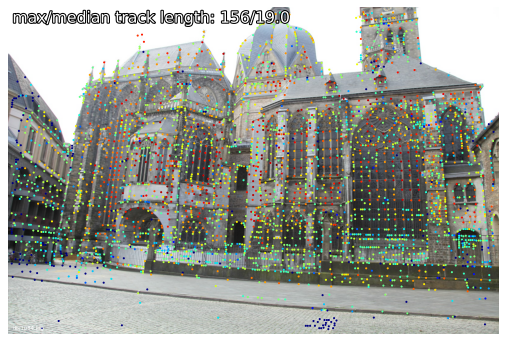

In [13]:
visualization.visualize_sfm_2d(reference_sfm, images, n=1, color_by='track_length')

Color the keypoints by visibility: blue if sucessfully triangulated, red if never matched.

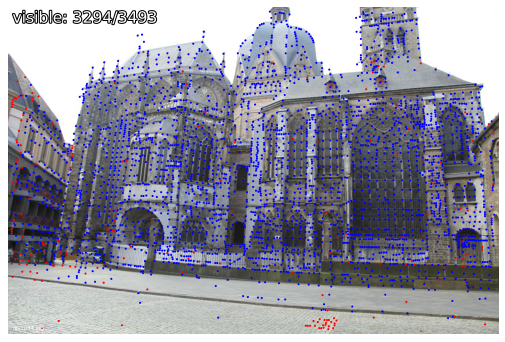

In [14]:
visualization.visualize_sfm_2d(reference_sfm, images, n=1, color_by='visibility')

Color the keypoints by triangulated depth: red keypoints are far away, blue keypoints are closer.

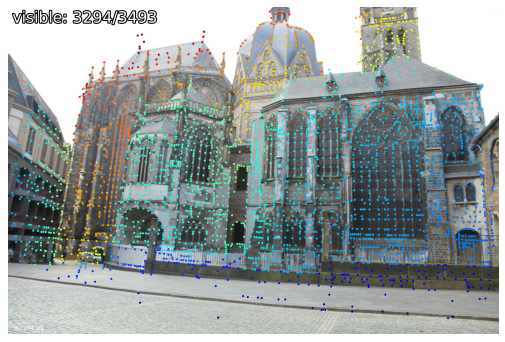

In [15]:
visualization.visualize_sfm_2d(reference_sfm, images, n=1, color_by='depth')

## Visualizing the localization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

In [16]:
visualization.visualize_loc(
    results, images, reference_sfm, n=1, top_k_db=1, prefix='q', seed=2)

IndexError: index 0 is out of bounds for axis 0 with size 0